In [1]:
from pathlib import Path

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from top2vec import Top2Vec

In [2]:
path_corpus_tut = Path('../data/corpora/clean_tutby_126784.csv')
path_points = Path('../data/model/points_clean_126784.npy')
path_plot = Path('../data/plot/topic_tag_clean_126784.html')
path_model_top2vec = Path('../data/model/top2vec_reduced_100_clean_126784.joblibfile')
reduced = True

In [3]:
data = pd.read_csv(path_corpus_tut)
data['tags'] = data['tags'].apply(eval)

print(data.shape)
display(data.head(3))

(126784, 6)


,url,label,header,date,document,tags
0,https://news.tut.by/550306.html,Футбол,"Тренер ""Шахтера"": Оправдываться не хочу. Все в...",2017-07-06T21:35:00+03:00,главный тренер солигорский шахтер олег кубарев...,[футбол]
1,https://news.tut.by/550307.html,Общество,"""Зацветет"" ли каменная роза на ул. Комсомольск...",2017-07-07T09:25:00+03:00,план восстановление рисунок пока художник илья...,"[архитектура, живопись, ЖКХ]"
2,https://news.tut.by/550308.html,Общество,Фотофакт. Скамейка в виде пожарной машины появ...,2017-07-07T09:27:00+03:00,областной управление мчс день пожарный служба ...,[министерства]


In [4]:
%%time

model = Top2Vec.load(path_model_top2vec)

assert(data.shape[0] == model.documents.shape[0])

print(model.documents.shape)
print(model.doc_top_reduced.shape)
print(model.topic_words_reduced.shape)

(126784,)
(126784,)
(100, 50)
Wall time: 5.83 s


In [5]:
topic_tags = pd.DataFrame()
topic_tags['topic'] = model.doc_top_reduced
topic_tags['tags'] = data['tags']

display(topic_tags.head(7))

,topic,tags
0,1,[футбол]
1,40,"[архитектура, живопись, ЖКХ]"
2,32,[министерства]
3,1,"[футбол, БАТЭ]"
4,84,"[Ситуация в Украине, государственные перевороты]"
5,1,"[футбол, Чемпионат Беларуси по футболу]"
6,53,[теннис]


In [6]:
print(topic_tags['topic'].value_counts()[:3])
print(topic_tags['topic'].value_counts()[-3:])
print(topic_tags['tags'].explode().value_counts()[:100][:3])
print(topic_tags['tags'].explode().value_counts()[:100][-3:])

0    4356
1    2538
2    2257
Name: topic, dtype: int64
97    822
98    815
99    806
Name: topic, dtype: int64
криминал               9061
правовая информация    8307
дети                   7748
Name: tags, dtype: int64
мошенничество, хулиганство    807
космос                        806
результаты торгов БВФБ        782
Name: tags, dtype: int64


In [7]:
%%time

n_predicted_tags = 5


tags = topic_tags['tags'].explode().value_counts()[:200].index
topics = topic_tags['topic'].unique()

values = []

for tag in tqdm(tags):
    
    is_tag = topic_tags['tags'].apply(lambda _: tag in _)
    n_tag = is_tag.sum()
    
    for topic in topics:
        is_topic = topic_tags['topic'] == topic
        n_topic = is_topic.sum()
        
        intersection = (is_topic & is_tag).sum()
        union = (is_topic | is_tag).sum()
        
        iou = intersection / union
        part_tag = intersection / n_tag
        part_topic = intersection / n_topic
        
        values += [(topic, tag, n_topic, n_tag, intersection, iou, part_topic, part_tag)]

values = pd.DataFrame(values, columns=['topic', 'tag', 'n_topic', 'n_tag', 'intersection', 'iou', 'part_topic', 'part_tag']) 

values['topic_words'] = model.topic_words_reduced[values['topic']][:,:n_predicted_tags].tolist()


print(values.shape)
display(values.head(5))


(20000, 9)


,topic,tag,n_topic,n_tag,intersection,iou,part_topic,part_tag,topic_words
0,1,криминал,2538,9061,16,0.001381,0.006304,0.001766,"[бате, борисовчанин, городея, еврокубок, еврок..."
1,40,криминал,1267,9061,17,0.001649,0.013418,0.001876,"[подъезд, жилец, жэс, заделывать, жэу]"
2,32,криминал,1330,9061,21,0.002025,0.015789,0.002318,"[художник, артобъект, скульптура, инсталляция,..."
3,84,криминал,962,9061,91,0.009162,0.094595,0.010043,"[порошенко, батькивщина, саакашвили, зеленскии..."
4,53,криминал,1150,9061,5,0.000490,0.004348,0.000552,"[ракетка, соболенко, саснович, арина, wta]"


Wall time: 29.5 s


In [8]:
tag_index_best = values.groupby('tag')['part_tag'].idxmax()
tag_mapping = values.loc[tag_index_best]
tag_mapping = tag_mapping.sort_values('part_tag', ascending=False)

tag_mapping.head(15)

,topic,tag,n_topic,n_tag,intersection,iou,part_topic,part_tag,topic_words
9957,95,результаты торгов БВФБ,833,782,777,0.927208,0.932773,0.993606,"[валюта, курсы, сглаживание, колебание, укрепл..."
19693,98,Дело отравленного шпиона,815,374,348,0.413793,0.426994,0.930481,"[скрипаль, скрипалыи, солсбери, эксполковник, ..."
13442,0,пешеходы,4356,589,547,0.124375,0.125574,0.928693,"[дтп, пдд, водитель, гаи, встречок]"
13247,2,КХЛ,2257,598,554,0.240765,0.245459,0.926421,"[хоккеист, шаиба, кхл, буллит, овертаим]"
14838,75,КНДР,1001,515,469,0.447947,0.468531,0.910680,"[пхеньян, кндр, денуклеаризация, ракетноядерны..."
16832,8,дизайн интерьера,1640,443,398,0.236202,0.242683,0.898420,"[санузел, гостиная, кухнягостиная, спальня, пр..."
18747,2,ХК Юность,2257,395,350,0.152042,0.155073,0.886076,"[хоккеист, шаиба, кхл, буллит, овертаим]"
6400,1,Чемпионат Беларуси по футболу,2538,1412,1228,0.451139,0.483846,0.869688,"[бате, борисовчанин, городея, еврокубок, еврок..."
16000,1,ФК Динамо Минск,2538,477,414,0.159170,0.163121,0.867925,"[бате, борисовчанин, городея, еврокубок, еврок..."
13047,2,"ХК ""Динамо"" Минск",2257,617,521,0.221419,0.230837,0.844408,"[хоккеист, шаиба, кхл, буллит, овертаим]"


In [9]:
topic_index_best = values.groupby('topic')['part_topic'].idxmax()
topic_mapping = values.loc[topic_index_best]
topic_mapping = topic_mapping.sort_values('part_topic', ascending=False)

topic_mapping.head(15)

,topic,tag,n_topic,n_tag,intersection,iou,part_topic,part_tag,topic_words
1799,82,Погода,963,4231,963,0.227606,1.000000,0.227606,"[малооблачноутро, пасмурноутро, облачностьутро..."
2847,2,Хоккей,2257,2952,2234,0.750924,0.989809,0.756775,"[хоккеист, шаиба, кхл, буллит, овертаим]"
1558,31,Автомобили,1347,4390,1323,0.299728,0.982183,0.301367,"[привод, трансмиссия, акп, переднии, бензиновыи]"
1721,15,Погода,1520,4231,1480,0.346523,0.973684,0.349799,"[погода, дождь, ветер, порыв, похолодать]"
900,1,футбол,2538,5028,2452,0.479468,0.966115,0.487669,"[бате, борисовчанин, городея, еврокубок, еврок..."
6004,53,теннис,1150,1435,1110,0.752542,0.965217,0.773519,"[ракетка, соболенко, саснович, арина, wta]"
978,19,футбол,1478,5028,1385,0.270455,0.937077,0.275457,"[атлетико, ливерпуль, реал, мадридскии, ювентус]"
9957,95,результаты торгов БВФБ,833,782,777,0.927208,0.932773,0.993606,"[валюта, курсы, сглаживание, колебание, укрепл..."
1042,0,ДТП,4356,4940,4061,0.775740,0.932277,0.822065,"[дтп, пдд, водитель, гаи, встречок]"
2490,87,банки,916,3555,851,0.235083,0.929039,0.239381,"[банк, альфабанка, дебетовыи, мтбанк, карта]"


In [10]:
print('tag_mapping:')
display(tag_mapping.sort_values('iou', ascending=False).head(10))

print('topic_mapping:')
display(topic_mapping.sort_values('iou', ascending=False).head(10))

print('values:')
display(values.sort_values('iou', ascending=False).head(10))
display(values.sort_values('intersection', ascending=False).head(10))

tag_mapping:


,topic,tag,n_topic,n_tag,intersection,iou,part_topic,part_tag,topic_words
9957,95,результаты торгов БВФБ,833,782,777,0.927208,0.932773,0.993606,"[валюта, курсы, сглаживание, колебание, укрепл..."
1042,0,ДТП,4356,4940,4061,0.775740,0.932277,0.822065,"[дтп, пдд, водитель, гаи, встречок]"
6004,53,теннис,1150,1435,1110,0.752542,0.965217,0.773519,"[ракетка, соболенко, саснович, арина, wta]"
2847,2,Хоккей,2257,2952,2234,0.750924,0.989809,0.756775,"[хоккеист, шаиба, кхл, буллит, овертаим]"
8998,94,Биатлон,840,1035,774,0.702997,0.921429,0.747826,"[массстарт, пасьют, антхолец, хохфильцен, биат..."
4727,18,смартфоны,1486,1817,1290,0.640835,0.868102,0.709961,"[полноэкранныи, fonearena, nubia, цветопередач..."
9888,81,космос,973,806,663,0.594086,0.681398,0.822581,"[орбита, nasa, астроном, телескоп, космическии]"
10470,92,Розыск,858,753,582,0.565598,0.678322,0.772908,"[псо, ориентировка, худощавыи, примета, одевать]"
14265,99,электромобиль,806,560,468,0.521158,0.580645,0.835714,"[электрокар, двс, электромобиль, электрокара, ..."
4983,14,пожары,1521,1750,1089,0.499083,0.715976,0.622286,"[пожар, возгорание, закапчивать, пожарныи, туш..."


topic_mapping:


,topic,tag,n_topic,n_tag,intersection,iou,part_topic,part_tag,topic_words
9957,95,результаты торгов БВФБ,833,782,777,0.927208,0.932773,0.993606,"[валюта, курсы, сглаживание, колебание, укрепл..."
1042,0,ДТП,4356,4940,4061,0.775740,0.932277,0.822065,"[дтп, пдд, водитель, гаи, встречок]"
6004,53,теннис,1150,1435,1110,0.752542,0.965217,0.773519,"[ракетка, соболенко, саснович, арина, wta]"
2847,2,Хоккей,2257,2952,2234,0.750924,0.989809,0.756775,"[хоккеист, шаиба, кхл, буллит, овертаим]"
8998,94,Биатлон,840,1035,774,0.702997,0.921429,0.747826,"[массстарт, пасьют, антхолец, хохфильцен, биат..."
10470,92,Розыск,858,753,582,0.565598,0.678322,0.772908,"[псо, ориентировка, худощавыи, примета, одевать]"
4983,14,пожары,1521,1750,1089,0.499083,0.715976,0.622286,"[пожар, возгорание, закапчивать, пожарныи, туш..."
900,1,футбол,2538,5028,2452,0.479468,0.966115,0.487669,"[бате, борисовчанин, городея, еврокубок, еврок..."
11713,85,Война в Сирии,949,658,516,0.472961,0.543730,0.784195,"[сирия, сириискии, идлиб, дамаск, идлиба]"
7695,96,Религия,827,1191,634,0.458092,0.766626,0.532326,"[верующии, веровать, церковь, богослужение, це..."


values:


,topic,tag,n_topic,n_tag,intersection,iou,part_topic,part_tag,topic_words
9957,95,результаты торгов БВФБ,833,782,777,0.927208,0.932773,0.993606,"[валюта, курсы, сглаживание, колебание, укрепл..."
1042,0,ДТП,4356,4940,4061,0.775740,0.932277,0.822065,"[дтп, пдд, водитель, гаи, встречок]"
6004,53,теннис,1150,1435,1110,0.752542,0.965217,0.773519,"[ракетка, соболенко, саснович, арина, wta]"
2847,2,Хоккей,2257,2952,2234,0.750924,0.989809,0.756775,"[хоккеист, шаиба, кхл, буллит, овертаим]"
8998,94,Биатлон,840,1035,774,0.702997,0.921429,0.747826,"[массстарт, пасьют, антхолец, хохфильцен, биат..."
4727,18,смартфоны,1486,1817,1290,0.640835,0.868102,0.709961,"[полноэкранныи, fonearena, nubia, цветопередач..."
9888,81,космос,973,806,663,0.594086,0.681398,0.822581,"[орбита, nasa, астроном, телескоп, космическии]"
10470,92,Розыск,858,753,582,0.565598,0.678322,0.772908,"[псо, ориентировка, худощавыи, примета, одевать]"
14265,99,электромобиль,806,560,468,0.521158,0.580645,0.835714,"[электрокар, двс, электромобиль, электрокара, ..."
4983,14,пожары,1521,1750,1089,0.499083,0.715976,0.622286,"[пожар, возгорание, закапчивать, пожарныи, туш..."


,topic,tag,n_topic,n_tag,intersection,iou,part_topic,part_tag,topic_words
1042,0,ДТП,4356,4940,4061,0.775740,0.932277,0.822065,"[дтп, пдд, водитель, гаи, встречок]"
900,1,футбол,2538,5028,2452,0.479468,0.966115,0.487669,"[бате, борисовчанин, городея, еврокубок, еврок..."
2847,2,Хоккей,2257,2952,2234,0.750924,0.989809,0.756775,"[хоккеист, шаиба, кхл, буллит, овертаим]"
1721,15,Погода,1520,4231,1480,0.346523,0.973684,0.349799,"[погода, дождь, ветер, порыв, похолодать]"
2351,6,вооружения,1828,3674,1457,0.360198,0.797046,0.396570,"[бомбардировщик, многоцелевои, надводныи, свер..."
978,19,футбол,1478,5028,1385,0.270455,0.937077,0.275457,"[атлетико, ливерпуль, реал, мадридскии, ювентус]"
2927,18,Гаджеты,1486,2880,1334,0.439974,0.897712,0.463194,"[полноэкранныи, fonearena, nubia, цветопередач..."
1558,31,Автомобили,1347,4390,1323,0.299728,0.982183,0.301367,"[привод, трансмиссия, акп, переднии, бензиновыи]"
4727,18,смартфоны,1486,1817,1290,0.640835,0.868102,0.709961,"[полноэкранныи, fonearena, nubia, цветопередач..."
2097,12,Коронавирус,1589,3953,1267,0.296374,0.797357,0.320516,"[заражение, инфицирование, инфицированныи, cov..."


In [11]:
%%time

topic = 18
tag = 'смартфоны'

is_topic = topic_tags['topic'] == topic
is_tag = topic_tags['tags'].apply(lambda _: tag in _)
intersection = is_topic & is_tag
only_topic = is_topic & ~intersection
only_tag = is_tag & ~intersection


with open(path_points, 'rb') as file:
    points = np.load(file)


colors = {
    0: 'lightgray',
    1: 'green',
    2: 'blue',
    3: 'orange',
}

color = (1 * intersection + 2 * only_topic + 3 * only_tag).replace(colors)


hover_data = {
    'url': data['url'], 
    'label': data['label'], 
    'header': data['header'], 
    'tags': data['tags'], 
    'predicted_tags': model.topic_words_reduced[model.doc_top_reduced][:, :n_predicted_tags].tolist()
}

fig = px.scatter(
    x=points[:, 0], 
    y=points[:, 1],
    color=color,
    color_discrete_map='identity',
    hover_data=hover_data, 
    width=1000, 
    height=1000,
)
fig.update_traces(marker=dict(size=4))

fig.write_html(str(path_plot))

Wall time: 14.7 s


In [12]:
tag = 'Президент'

index = values['tag'] == tag
values_tag = values[index].sort_values('part_tag', ascending=False)
display(values_tag.head(5))

,topic,tag,n_topic,n_tag,intersection,iou,part_topic,part_tag,topic_words
3475,55,Президент,1127,2478,393,0.122354,0.348713,0.158596,"[народ, искренне, уважение, патриотизм, уважать]"
3476,44,Президент,1217,2478,293,0.086126,0.240756,0.118241,"[интеграционныи, союзныи, интеграция, наднацио..."
3456,59,Президент,1114,2478,275,0.082906,0.246858,0.110977,"[хозяиство, минсельхозпрод, молочнотоварныи, ж..."
3486,30,Президент,1355,2478,119,0.032041,0.087823,0.048023,"[цик, ермошин, центризбирком, избирательныи, е..."
3422,86,Президент,921,2478,84,0.025339,0.091205,0.033898,"[воинскии, военнослужащии, равки, солдат, дедо..."


,topic,tag,n_topic,n_tag,intersection,iou,part_topic,part_tag,topic_words
3252,3,акции протеста,2143,2676,1020,0.268492,0.475968,0.381166,"[ивс, штатское, омон, окрестин, пикетирование]"
452,3,милиция,2143,6372,867,0.113363,0.404573,0.136064,"[ивс, штатское, омон, окрестин, пикетирование]"
3652,3,Выборы-2020,2143,2158,623,0.169386,0.290714,0.288693,"[ивс, штатское, омон, окрестин, пикетирование]"
552,3,суды,2143,6317,580,0.073604,0.270649,0.091816,"[ивс, штатское, омон, окрестин, пикетирование]"
152,3,правовая информация,2143,8307,554,0.055982,0.258516,0.066691,"[ивс, штатское, омон, окрестин, пикетирование]"


,url,label,header,date,document,tags
115895,https://news.tut.by/687451.html,Выборы,В Гродно задерживали координатора инициативной...,2020-06-04T17:18:00+03:00,гродно задерживать ольга корякин координатор и...,"[Выборы-2020, милиция, права человека]"
115873,https://news.tut.by/687428.html,Выборы,В Гродно задержали волонтера инициативной груп...,2020-06-04T15:36:00+03:00,гродно площадь советский задерживать гродненец...,[Выборы-2020]
98207,https://news.tut.by/666705.html,Деньги и власть,"Северинца ОМОН свозил в суд, где его оштрафова...",2019-12-26T16:35:00+03:00,павел северинец задерживать утро омон отвозить...,"[политика, акции протеста, правовая информация..."
117122,https://news.tut.by/688874.html,Выборы,В Бресте задержали пресс-секретаря инициативно...,2020-06-15T19:56:00+03:00,июнь брест задерживать александр кабанов пресс...,"[Выборы-2020, права человека]"
118501,https://news.tut.by/690551.html,Выборы,Пресс-секретарь инициативной группы Светланы Т...,2020-06-26T17:42:00+03:00,пресссекретарь инициативный группа претендент ...,"[Выборы-2020, Дело Тихановского, права человека]"


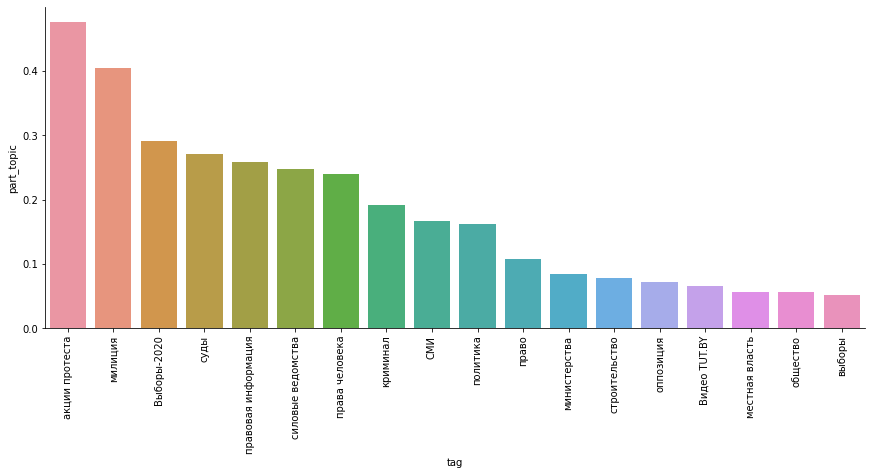

In [13]:
topic = 'ивс'  # 'ивс' 'электрокар' 'народ'


index = values['topic_words'].apply(lambda _: topic in _)
values_topic = values[index].sort_values('part_topic', ascending=False)
display(values_topic.head(5))

topic_id = values_topic['topic'].iloc[0]


documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic_id, num_docs=5, reduced=reduced)
display(data.loc[document_ids])


temp = values_topic[values_topic['part_topic'] > 0.05]
sns.catplot(x='tag', y='part_topic', kind='bar', data=temp, height=5, aspect=12/5);
plt.xticks(rotation=90);